## Setup 

In [1]:
from pathlib import Path
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm as progress_bar

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import sklearn.model_selection
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.model_selection import train_test_split


import emlearn
from emlearn.evaluate.trees import model_size_bytes, compute_cost_estimate
from emlearn.evaluate import size as em_size

/home/simong/workspace/EdgeSpell/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Import 

In [ ]:
def find_data_root() -> Path:
    here = Path.cwd()
    candidates = [
        here / "home-made" / "data",
        here / "data",
        here.parent / "data",
    ]
    for candidate in candidates:
        if candidate.is_dir():
            return candidate
    tried = ", ".join(str(c) for c in candidates)
    raise FileNotFoundError(f"Could not find data directory. Tried: {tried}")

DATA_ROOT = find_data_root()

def load_dataset(data_dir: Path):
    """Load all CSVs in data_dir; label is derived from filename stem."""
    frames = []
    for csv_path in sorted(data_dir.glob("*.csv")):
        label = csv_path.stem  # filename (without extension) is the label
        df = pd.read_csv(csv_path)
        df["label"] = label
        frames.append(df)
    if not frames:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    combined = pd.concat(frames, ignore_index=True)
    y = combined.pop("label")
    X = combined
    return X, y

X_all, y_all = load_dataset(DATA_ROOT)

# Keep backward-compatible names for downstream visualization cells
X_train = X_all
y_train = y_all

feature_names = X_all.columns.tolist()
class_names = sorted(y_all.unique())

print(f"Using data root: {DATA_ROOT}")
print(f"Loaded {X_all.shape[0]} samples with {len(class_names)} classes.")
print(f"Features per sample: {X_all.shape[1]}")
print("Classes:", class_names)


Using data root: /home/simong/workspace/EdgeSpell/home-made/data
Loaded 1845 samples with 6 classes.
Features per sample: 600
Classes: ['circle', 'downup', 'leftright', 'lightning', 'rightleft', 'updown']


## Data Visualization

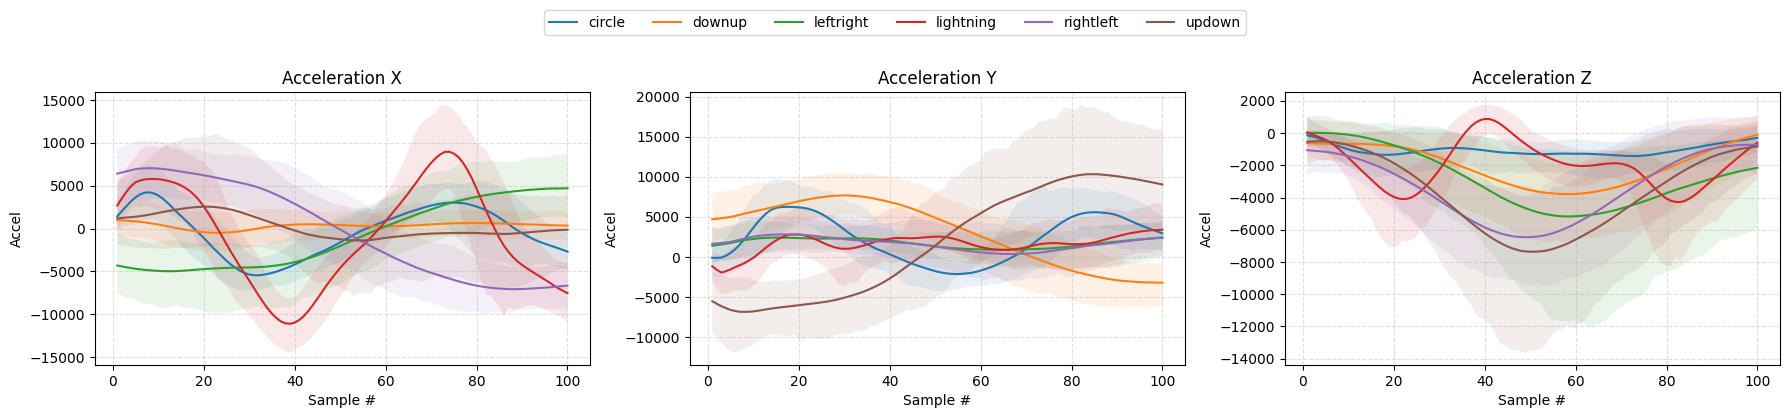

In [3]:

# Visualize acceleration profiles per class with 5th/95th percentile bands
ACCEL_AXES = ("X", "Y", "Z")

def accel_columns(axis: str):
    cols = [c for c in X_train.columns if c.endswith(f"Accel_{axis}")]
    cols.sort(key=lambda name: int(name.split("_")[0].replace("Sample", "")))
    return cols

sample_numbers = None
fig, axes = plt.subplots(1, len(ACCEL_AXES), figsize=(18, 4), sharey=False)
axes = np.atleast_1d(axes)

for ax_idx, axis in enumerate(ACCEL_AXES):
    cols = accel_columns(axis)
    if sample_numbers is None:
        sample_numbers = [int(col.split("_")[0].replace("Sample", "")) for col in cols]
    ax = axes[ax_idx]
    for label in class_names:
        mask = y_train == label
        data = X_train.loc[mask, cols].to_numpy()
        mean = data.mean(axis=0)
        lower = np.percentile(data, 5, axis=0)
        upper = np.percentile(data, 95, axis=0)
        ax.plot(sample_numbers, mean, label=label)
        ax.fill_between(sample_numbers, lower, upper, alpha=0.1)
    ax.set_title(f"Acceleration {axis}")
    ax.set_xlabel("Sample #")
    ax.set_ylabel("Accel")
    ax.grid(True, linestyle="--", alpha=0.4)

# Use only the first axes for legend handles to avoid duplicates
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(class_names), loc="upper center", bbox_to_anchor=(0.5, 1.05))
fig.tight_layout(rect=[0, 0, 1, 0.92])


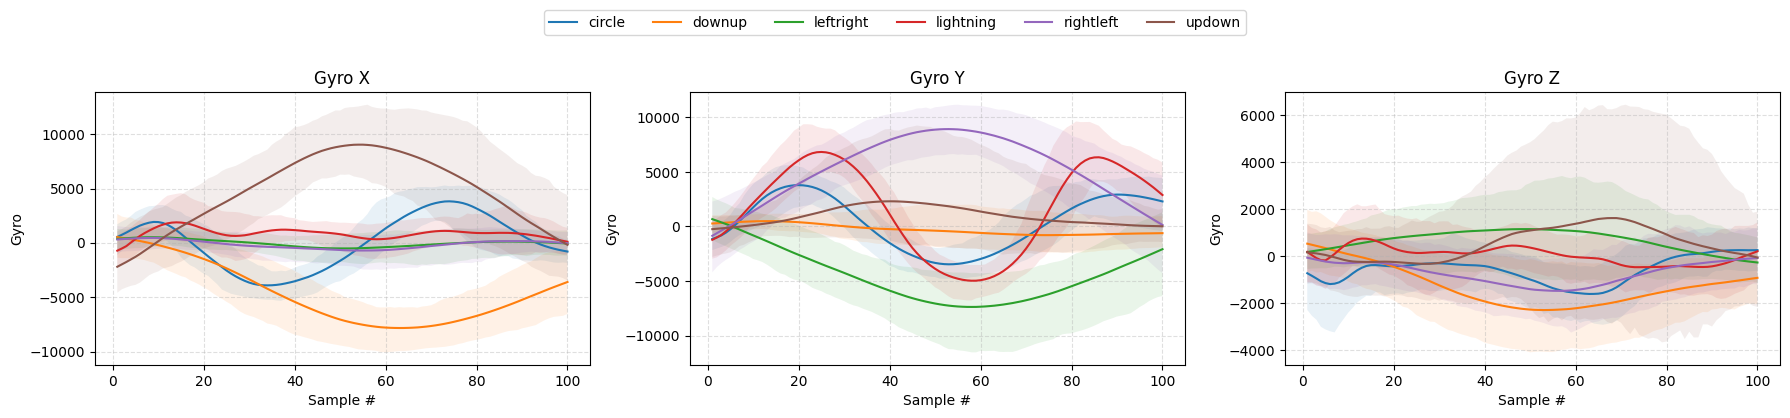

In [4]:
# Visualize gyro profiles per class with 5th/95th percentile bands
GYRO_AXES = ("X", "Y", "Z")

def gyro_columns(axis: str):
    cols = [c for c in X_train.columns if c.endswith(f"Gyro_{axis}")]
    cols.sort(key=lambda name: int(name.split("_")[0].replace("Sample", "")))
    return cols

sample_numbers = None
fig, axes = plt.subplots(1, len(GYRO_AXES), figsize=(18, 4), sharey=False)
axes = np.atleast_1d(axes)

for ax_idx, axis in enumerate(GYRO_AXES):
    cols = gyro_columns(axis)
    if sample_numbers is None:
        sample_numbers = [int(col.split("_")[0].replace("Sample", "")) for col in cols]
    ax = axes[ax_idx]
    for label in class_names:
        mask = y_train == label
        data = X_train.loc[mask, cols].to_numpy()
        mean = data.mean(axis=0)
        lower = np.percentile(data, 5, axis=0)
        upper = np.percentile(data, 95, axis=0)
        ax.plot(sample_numbers, mean, label=label)
        ax.fill_between(sample_numbers, lower, upper, alpha=0.1)
    ax.set_title(f"Gyro {axis}")
    ax.set_xlabel("Sample #")
    ax.set_ylabel("Gyro")
    ax.grid(True, linestyle="--", alpha=0.4)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(class_names), loc="upper center", bbox_to_anchor=(0.5, 1.05))
fig.tight_layout(rect=[0, 0, 1, 0.92])


## Random Forest Benchmark (Accuracy / Size / Compute)

Benchmarks RandomForest models over `n_estimators` and `max_depth` using repeated train/test splits.
Metrics: balanced accuracy, mean test accuracy, estimated compute cost, and compiled FLASH/RAM size via `emlearn.evaluate.size.get_program_size`.
The size/compute estimates target ARM Cortex-M4F by default; adjust the platform/MCU if needed.


In [5]:
# Combine all IMU samples so each trial can draw fresh splits
all_features = X_all.copy()
all_labels = y_all.reset_index(drop=True)

N_ESTIMATORS_GRID = [2, 5, 10, 25, 50, 75, 100]
MAX_DEPTH_GRID = [2, 4, 6, 8, 10, None]
REPEATS_PER_MODEL = 10 
TEST_FRACTION = 0.25
TARGET_PLATFORM = 'arm'
TARGET_MCU = 'Cortex-M4F'


In [6]:
def summarize_compute_cost(cost):
    if isinstance(cost, dict):
        for key in ('mean', 'total', 'median'):
            if key in cost:
                return float(cost[key])
        return float(cost.get('mean', float('nan')))
    return float(cost)

def estimate_program_size(estimator, name='rf_model', platform=TARGET_PLATFORM, mcu=TARGET_MCU):
    platform_dir = Path(em_size.platforms_dir).resolve()
    if not platform_dir.exists():
        return {'flash': None, 'ram': None, 'note': f"Missing platform files at {platform_dir}"}
    missing_tools = em_size.check_build_tools(platform)
    if missing_tools:
        return {'flash': None, 'ram': None, 'note': missing_tools}
    try:
        cmodel = emlearn.convert(estimator, method='inline')
        c_code = cmodel.save(name=name)
        stub = f"""
                #pragma GCC diagnostic push
                #pragma GCC diagnostic ignored \"-Wunused-parameter\"
                {c_code}
                #pragma GCC diagnostic pop
                int main(void) {{
                    {cmodel.dtype} features[{cmodel.n_features}] = {{0}};
                    return {name}_predict(features, {cmodel.n_features});
                }}
                """
        sizes = em_size.get_program_size(stub, platform=platform, mcu=mcu)
        sizes['note'] = None
        return sizes
    except Exception as exc:
        return {'flash': None, 'ram': None, 'note': str(exc)}

def benchmark_config(params, repeats=REPEATS_PER_MODEL, test_size=TEST_FRACTION):
    trials = []
    size_info = None
    for seed in range(repeats):
        X_tr, X_va, y_tr, y_va = train_test_split(
            all_features, all_labels, test_size=test_size, random_state=seed, stratify=all_labels
        )
        clf = RandomForestClassifier(n_jobs=-1, random_state=seed, **params)
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_va)

        acc = accuracy_score(y_va, y_pred)
        bal_acc = balanced_accuracy_score(y_va, y_pred)
        compute = summarize_compute_cost(compute_cost_estimate(clf, X_va))

        if size_info is None:
            size_info = estimate_program_size(
                clf, name=f"rf_{params['n_estimators']}_{params['max_depth'] if params['max_depth'] is not None else 'None'}"
            )

        trials.append({
            'param_n_estimators': params['n_estimators'],
            'param_max_depth': params['max_depth'],
            'seed': seed,
            'accuracy': acc,
            'balanced_accuracy': bal_acc,
            'compute': compute,
            'flash_bytes': size_info.get('flash'),
            'ram_bytes': size_info.get('ram'),
            'size_note': size_info.get('note'),
        })

    df = pd.DataFrame(trials)
    summary = {
        'param_n_estimators': params['n_estimators'],
        'param_max_depth': params['max_depth'],
        'trials': len(df),
        'mean_test_accuracy': df['accuracy'].mean(),
        'mean_balanced_accuracy': df['balanced_accuracy'].mean(),
        'mean_test_compute': df['compute'].mean(),
        'flash_bytes': df['flash_bytes'].dropna().iloc[0] if df['flash_bytes'].notna().any() else None,
        'ram_bytes': df['ram_bytes'].dropna().iloc[0] if df['ram_bytes'].notna().any() else None,
        'size_note': next((note for note in df['size_note'] if pd.notna(note)), None),
    }
    return df, summary



In [7]:
rf_bench_trials = []
rf_bench_summaries = []

for n_estimators in progress_bar(N_ESTIMATORS_GRID, desc='n_estimators'):
    for max_depth in progress_bar(MAX_DEPTH_GRID, desc='max_depth', leave=False):
        cfg = {'n_estimators': n_estimators, 'max_depth': max_depth}
        trial_df, summary = benchmark_config(cfg)
        rf_bench_trials.append(trial_df)
        rf_bench_summaries.append(summary)

rf_bench_trials = pd.concat(rf_bench_trials, ignore_index=True)
rf_bench_summary = pd.DataFrame(rf_bench_summaries)

display(rf_bench_summary.sort_values('mean_balanced_accuracy', ascending=False).head())
rf_bench_summary.head()


n_estimators: 100%|██████████| 7/7 [02:45<00:00, 23.65s/it]


,param_n_estimators,param_max_depth,trials,mean_test_accuracy,mean_balanced_accuracy,mean_test_compute,flash_bytes,ram_bytes,size_note
28,50,10.0,10,0.999784,0.999792,246.909091,11468,1100,None
29,50,NaN,10,0.999784,0.999792,246.911255,11468,1100,None
40,100,10.0,10,0.999784,0.999792,493.553463,20772,1100,None
41,100,NaN,10,0.999784,0.999792,493.555628,20772,1100,None
39,100,8.0,10,0.999784,0.999792,493.371212,20736,1100,None


,param_n_estimators,param_max_depth,trials,mean_test_accuracy,mean_balanced_accuracy,mean_test_compute,flash_bytes,ram_bytes,size_note
0,2,2.0,10,0.674675,0.653492,5.821861,2144,1100,None
1,2,4.0,10,0.910390,0.900734,8.493723,2268,1100,None
2,2,6.0,10,0.986364,0.986154,9.873377,2432,1100,None
3,2,8.0,10,0.983766,0.983490,9.994589,2404,1100,None
4,2,10.0,10,0.983983,0.983693,10.001948,2404,1100,None


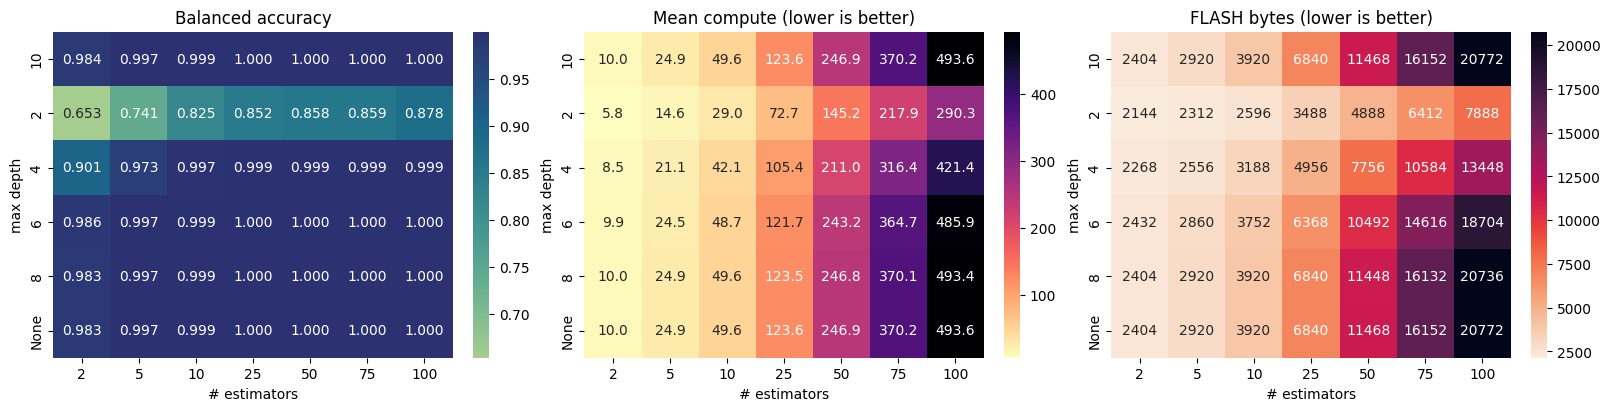

In [8]:

viz_df = rf_bench_summary.copy()
viz_df['depth_label'] = viz_df['param_max_depth'].apply(lambda d: 'None' if pd.isna(d) else str(int(d)))

def plot_heatmap(metric, ax, cmap='Blues', fmt='.3f'):
    pivot = viz_df.pivot(index='depth_label', columns='param_n_estimators', values=metric)
    sns.heatmap(pivot, annot=True, fmt=fmt, cmap=cmap, ax=ax)
    ax.set_xlabel('# estimators')
    ax.set_ylabel('max depth')

fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
plot_heatmap('mean_balanced_accuracy', axes[0], cmap='crest', fmt='.3f')
axes[0].set_title('Balanced accuracy')
plot_heatmap('mean_test_compute', axes[1], cmap='magma_r', fmt='.1f')
axes[1].set_title('Mean compute (lower is better)')
plot_heatmap('flash_bytes', axes[2], cmap='rocket_r', fmt='.0f')
axes[2].set_title('FLASH bytes (lower is better)')
plt.show()


In [9]:
def top_k(df, metric, k=3, largest=True):
    ordered = df.dropna(subset=[metric]).sort_values(metric, ascending=not largest)
    cols = ['param_n_estimators', 'param_max_depth', metric, 'flash_bytes', 'ram_bytes', 'size_note']
    return ordered.head(k)[cols]

print('Top 3 balanced accuracy:')
display(top_k(rf_bench_summary, 'mean_balanced_accuracy', largest=True))
print('Top 3 mean test accuracy:')
display(top_k(rf_bench_summary, 'mean_test_accuracy', largest=True))
print('Top 3 smallest compute estimate:')
display(top_k(rf_bench_summary, 'mean_test_compute', largest=False))
print('Top 3 smallest FLASH size:')
display(top_k(rf_bench_summary, 'flash_bytes', largest=False))


Top 3 balanced accuracy:


,param_n_estimators,param_max_depth,mean_balanced_accuracy,flash_bytes,ram_bytes,size_note
28,50,10.0,0.999792,11468,1100,None
29,50,NaN,0.999792,11468,1100,None
40,100,10.0,0.999792,20772,1100,None


Top 3 mean test accuracy:


,param_n_estimators,param_max_depth,mean_test_accuracy,flash_bytes,ram_bytes,size_note
28,50,10.0,0.999784,11468,1100,None
29,50,NaN,0.999784,11468,1100,None
40,100,10.0,0.999784,20772,1100,None


Top 3 smallest compute estimate:


,param_n_estimators,param_max_depth,mean_test_compute,flash_bytes,ram_bytes,size_note
0,2,2.0,5.821861,2144,1100,None
1,2,4.0,8.493723,2268,1100,None
2,2,6.0,9.873377,2432,1100,None


Top 3 smallest FLASH size:


,param_n_estimators,param_max_depth,flash_bytes,flash_bytes,ram_bytes,size_note
0,2,2.0,2144,2144,1100,None
1,2,4.0,2268,2268,1100,None
6,5,2.0,2312,2312,1100,None


In [10]:
# Model selection helpers and export
import re
BUILDS_DIR = Path("builds")
BUILDS_DIR.mkdir(exist_ok=True)

def _normalize(series):
    s = series.fillna(series.max())
    denom = s.max() - s.min()
    return (s - s.min()) / denom if denom else s*0

def _clean_c_identifier(name: str) -> str:
    cleaned = re.sub(r'[^0-9a-zA-Z_]', '_', name)
    if not cleaned or (not cleaned[0].isalpha() and cleaned[0] != '_'):
        cleaned = f"m_{cleaned}"
    return cleaned

def pick_by_weights(df, w_bal_acc=1.0, w_compute=0.0, w_flash=0.0):
    work = df.copy()
    work['score'] = (
        w_bal_acc * work['mean_balanced_accuracy']
        - w_compute * _normalize(work['mean_test_compute'])
        - w_flash * _normalize(work['flash_bytes'])
    )
    return work.sort_values('score', ascending=False).iloc[0]

def train_and_export(params, name_prefix, out_dir=BUILDS_DIR):
    n_est = int(params['param_n_estimators'])
    depth_raw = params['param_max_depth']
    depth_val = 'none' if depth_raw in ('None', None) or pd.isna(depth_raw) else str(int(depth_raw))
    base_name = f"{name_prefix}_{n_est}_{depth_val}"
    c_name = _clean_c_identifier(base_name)

    clf = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=None if depth_raw in ('None', None) or pd.isna(depth_raw) else int(depth_raw),
        n_jobs=-1,
        random_state=0,
    )
    clf.fit(X_all, y_all)
    cmodel = emlearn.convert(clf, method='inline')
    c_code = cmodel.save(name=c_name)
    out_path = out_dir / f"{c_name}.c"
    out_path.write_text(c_code)
    return out_path

# Method 1: weighted blend of balanced accuracy (higher) vs compute/flash (lower)
weights = dict(w_bal_acc=1.0, w_compute=0.3, w_flash=0.1)
best_weighted = pick_by_weights(rf_bench_summary, **weights)
weighted_path = train_and_export(best_weighted, name_prefix="rf_wt")
print("Weighted best:")
print(best_weighted[['param_n_estimators','param_max_depth','mean_balanced_accuracy','mean_test_compute','flash_bytes','ram_bytes','score']])
print("C export:", weighted_path)

# Method 2: prioritize accuracy, then smallest memory, under a compute budget
compute_budget = 200.0  # adjust to your target compute metric
filtered = rf_bench_summary[rf_bench_summary['mean_test_compute'] <= compute_budget].dropna(subset=['flash_bytes','ram_bytes'])
if not filtered.empty:
    best_perf = filtered.sort_values(
        ['mean_test_accuracy', 'flash_bytes', 'ram_bytes'],
        ascending=[False, True, True]
    ).iloc[0]
    perf_path = train_and_export(best_perf, name_prefix="rf_perf")
    print("Budgeted best:")
    print(best_perf[['param_n_estimators','param_max_depth','mean_test_accuracy','mean_test_compute','flash_bytes','ram_bytes']])
    print("C export:", perf_path)
else:
    print(f"No models meet compute budget <= {compute_budget}")



Weighted best:
param_n_estimators               2
param_max_depth                6.0
mean_balanced_accuracy    0.986154
mean_test_compute         9.873377
flash_bytes                   2432
ram_bytes                     1100
score                     0.982116
Name: 2, dtype: object
C export: builds/rf_wt_2_6.c
Budgeted best:
param_n_estimators            25
param_max_depth              6.0
mean_test_accuracy      0.999567
mean_test_compute     121.679221
flash_bytes                 6368
ram_bytes                   1100
Name: 20, dtype: object
C export: builds/rf_perf_25_6.c


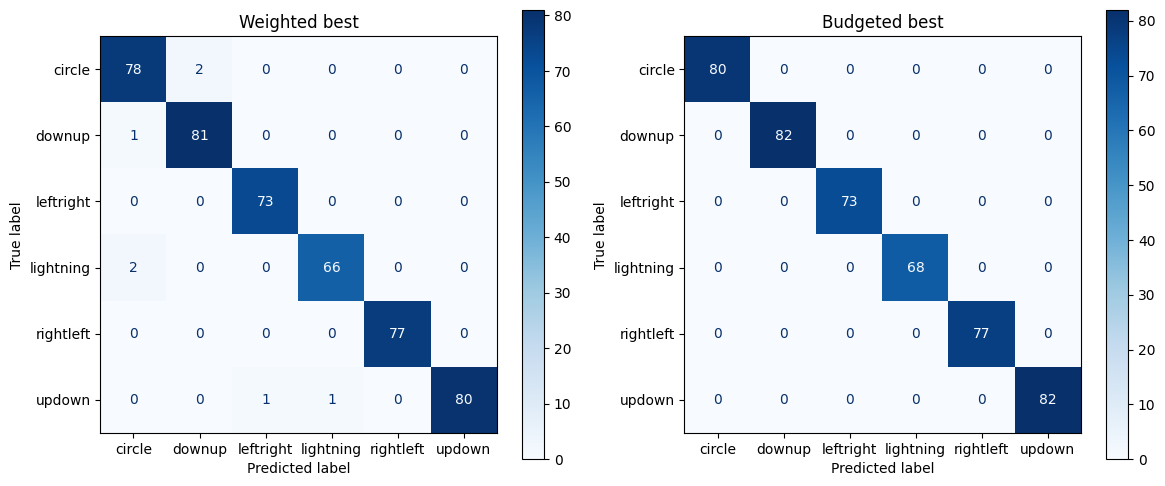

In [13]:
# Confusion matrices for the exported models

def _resolve_max_depth(value):
    return None if pd.isna(value) else int(value)

SPLIT_RANDOM_STATE = 42
TEST_SIZE = 0.25

X_tr_split, X_te_split, y_tr_split, y_te_split = train_test_split(
    X_all,
    y_all,
    test_size=TEST_SIZE,
    stratify=y_all,
    random_state=SPLIT_RANDOM_STATE,
)

def fit_rf_for_params(params, seed):
    clf = RandomForestClassifier(
        n_estimators=int(params['param_n_estimators']),
        max_depth=_resolve_max_depth(params['param_max_depth']),
        n_jobs=-1,
        random_state=seed,
    )
    clf.fit(X_tr_split, y_tr_split)
    return clf

def plot_confusion(ax, clf, X_test, y_test, title):
    y_pred = clf.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        labels=class_names,
        normalize=None,
        cmap='Blues',
        ax=ax,
    )
    ax.set_title(title)

wt_clf = fit_rf_for_params(best_weighted, seed=0)
has_perf = 'best_perf' in globals() and best_perf is not None
axes_needed = 2 if has_perf else 1
fig, axes = plt.subplots(1, axes_needed, figsize=(12, 5))
axes = np.atleast_1d(axes)

plot_confusion(axes[0], wt_clf, X_te_split, y_te_split, "Weighted best")

if has_perf:
    perf_clf = fit_rf_for_params(best_perf, seed=1)
    plot_confusion(axes[1], perf_clf, X_te_split, y_te_split, "Budgeted best")

fig.tight_layout()
